# Convolutional Neural Nets

CNNs are designed to learn from spatial data - including images, 3d volumes, graphs, and more. For simplicity, we will focus on the application to image data.

In [1]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

First, let's grab an example image, use a CNN layer to process it, and see if we can calculate the output image.

[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]


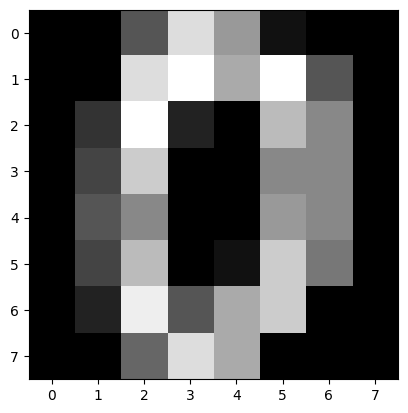

In [2]:
data = load_digits()
image = data['data'][0,:] # images are packed as 1d vectors
image = np.reshape(image, (8,8)) #reshape to be a 2d matrix
print(image)
plt.imshow(image, cmap='gray')

Image data is represented on a per-pixel basis, so that each pixel is encoded with a brightness value. For color images, each pixel is encoded with an RGB value.

Our CNN layer will slide a window across the image and produce a value at each step. The CNN has several parameters that can be specified to control how it scans.

    Kernel size: how large the window is, in pixels.
    Stride: how many pixels are skipped before each convolution is taken
    Padding: whether extra pixels are added to the edges of images or not

From these parameters, you can calculate the exact dimensions of the output image. Let's try some examples.

In [3]:
# prepare our data for our CNN. a torch CNN expects data to follow this format
# [batch_size, channels, pixels horizontal, pixels vertical]
image = np.reshape(image, (1, 1, 8, 8))
image = torch.tensor(image, dtype = torch.float32)

In [4]:
conv = nn.Conv2d(
    in_channels = 1, # our image is black and white, so only 1 channel (RGB has 3 channels)
    out_channels = 1, # or number of kernels to train
    kernel_size = (3, 3), # the window is of size 3x3
    stride = (1, 1), # only move one pixel between convolutions
    padding = (0, 0) # amount of extra pixels to add to the top and sides of our image
)

# pass the image through our CNN. what will be the shape of the output?
output = conv(image)
print(output.shape)

torch.Size([1, 1, 6, 6])


Given our image's input shape (8x8), or any image's shape, could we calculate the output from a given `Conv2d` layer ahead of time?

Try writing the formula to do this by hand

In [6]:
def calculate_output_shape(image_size: list[int], kernel: list[int], stride: list[int], padding: list[int]):
    assert len(image_size) == len(kernel) == len(stride) == len(padding), "All values should have the same length"
    output_shape = []
    for dim in range(len(image_size)):
        shape = (1 + (image_size[dim] + (2 * padding[dim]) - kernel[dim]) / stride[dim])
        assert shape.is_integer(), "Change kernel, padding, and stride such that output shape is an integer"
        output_shape.append(shape)
    return output_shape

calculate_output_shape([8,8],[3,3],[1,1],[0,0])

[6.0, 6.0]

Each kernel (or filter) of our Conv2d is learned to extract features from the training data. CNNs come with a nice perk of being able to see what each kernel looks like after training. This can potentially tell us something about what our model has learned.

We can demonstrate this with a simple example of a CNN trained to recognize the number 3. If we set the kernel size to equal the image size, we can see this in practice.

In [7]:
conv_1kernel = nn.Conv2d(
    in_channels = 1, # our image is black and white, so only 1 channel (RGB has 3 channels)
    out_channels = 1, # or number of kernels to train
    kernel_size = (8, 8), # the window is of size 3x3
    stride = (1, 1), # only move one pixel between convolutions
    padding = (0, 0) # amount of extra pixels to add to the top and sides of our image
)

In [8]:
# do some clever numpy indexing to grab all examples of 3s from our dataset
x = data['data'][data['target'] == 3]
y = data['target'][data['target'] == 3]

# prep the data for training
x = np.reshape(x, (len(x), 1, 8, 8))
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# lets set up a training loop, and save snapshots of each kernel every epoch
optimizer = torch.optim.Adam(conv_1kernel.parameters(), lr = 0.001)
loss_fn = torch.nn.BCEWithLogitsLoss(reduction = 'none')
kernels = []

kernels.append([param.detach().numpy().copy() for param in conv_1kernel.parameters()][0])
for _ in range(10):
    for i in range(len(x)):
        optimizer.zero_grad()
        yhat = torch.squeeze(conv_1kernel(x[i:i+1]))
        loss = loss_fn(y[i], yhat)
        loss.backward()
        optimizer.step()
    kernels.append([param.detach().numpy().copy() for param in conv_1kernel.parameters()][0])

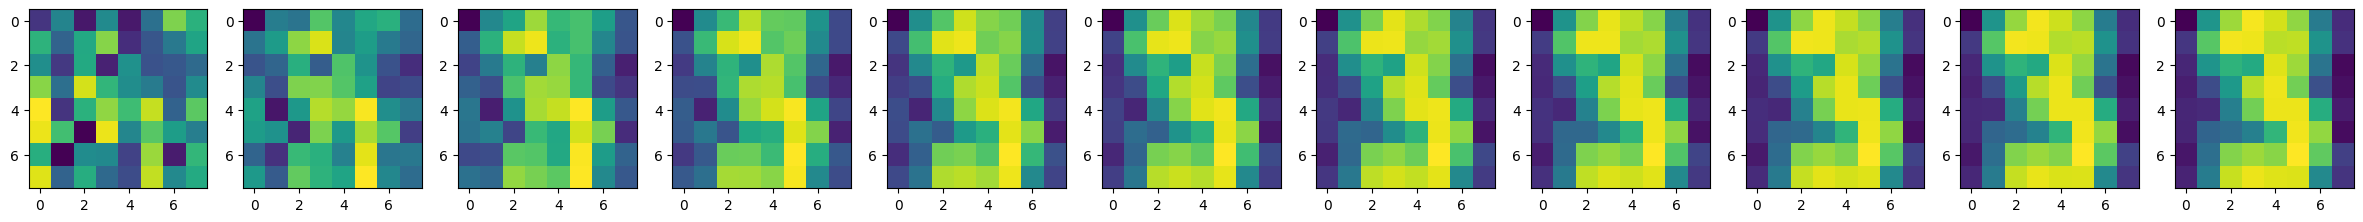

In [9]:
fig, axs = plt.subplots(1, 11, figsize=(30,3))

for i in range(len(kernels)):
    axs[i].imshow(kernels[i][0,0])

Indeed, our kernel is learning to look more and more like a 3. A typical CNN will have hundreds to thousands of kernels that are far smaller than the size of the input image, so interpreting them visually can be more challenging.

Also, CNNs can easily "stack" such that the output of one `Conv2d` layer is fed into the input of the next. Here, I have the first layer of a CNN written out. Fill in the following layers that are commented out, so that the final output is of a shape `(*,64,1,1)`. Then, add a final fully connected layer that converts the output into shape `(*,10)`.

In [10]:
example_img = torch.rand((1,1,28,28))

conv1 = nn.Conv2d(
    in_channels = 1, 
    out_channels = 16,
    kernel_size = (5, 5), 
    stride = (1, 1),
    padding = (0, 0),
)

maxpool1 = nn.MaxPool2d(kernel_size=(3,3),
                       stride = (2,2),
                       padding=(0,0),)
conv2 = nn.Conv2d(
    in_channels = 16, 
    out_channels = 64, 
    kernel_size = (3, 3), 
    stride = (2, 2), 
    padding = (0, 0),
)
maxpool2 = nn.MaxPool2d(kernel_size=(5,5),
                       stride = (2,2),
                       padding=(0,0),)

linear1 = nn.Linear(in_features=64,
                    out_features=10)

Now that you have the final shape, think about how you have transformed the data from a spatially-sensitive 2d matrix, to a kernel-sensitive 1d vector. Essentially, you have compressed the image. Now create a class from your layers so we can re-use it.

In [11]:

class CNNClassifier(nn.Module):
    def __init__(self, output_dim: int):
        super(CNNClassifier, self).__init__()
        assert output_dim > 0, "Output dimension must be a positive integer"
        self.conv1 = nn.Conv2d(
            in_channels = 1, 
            out_channels = 16,
            kernel_size = (5, 5), 
            stride = (1, 1),
            padding = (0, 0),
        )
        self.maxpool1 = nn.MaxPool2d(kernel_size=(3,3),
                       stride = (2,2),
                       padding=(0,0),)
        self.conv2 = nn.Conv2d(
            in_channels = 16, 
            out_channels = 64, 
            kernel_size = (3, 3), 
            stride = (2, 2), 
            padding = (0, 0),
        )
        self.maxpool2 = nn.MaxPool2d(kernel_size=(5,5),
                            stride = (2,2),
                            padding=(0,0),)
        self.linear1 = nn.Linear(in_features=64,
                            out_features=output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool2(x)
        # reshape for linear layer
        x = x[:,:,0,0]
        x = self.linear1(x)     
        x = torch.sigmoid(x)  
        return x

Now, let's grab a real image dataset from `torch`. We can use Fashion MNIST, which is like the MNIST digits dataset but more challenging to learn. Check it out here https://github.com/zalandoresearch/fashion-mnist

`pip install torchvision` if you don't have it

(<PIL.Image.Image image mode=L size=28x28 at 0x16B58AC70>, 9)


/Users/astrini/Documents/ECEGR4750/ECEGR4750/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


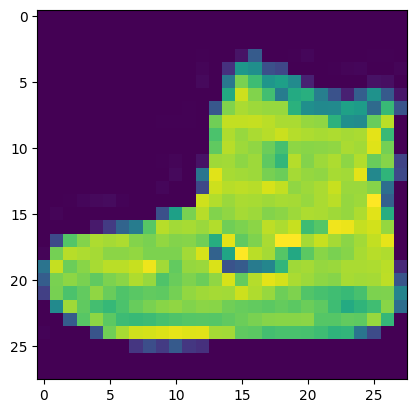

In [12]:
import torchvision

# creates a data object
fashion_mnist_train = torchvision.datasets.FashionMNIST(root = './', download=True, train=True)
fashion_mnist_val = torchvision.datasets.FashionMNIST(root = './', download=True, train=False)

# we can fetch an item from the data like so, which gives us the image in PIL form, and the class label as an int
print(fashion_mnist_train.__getitem__(0))

# we can convert the image to a numpy array like so
img = fashion_mnist_train.__getitem__(0)[0]
img = np.array(img)

# and here is a shoe
plt.imshow(img)

To speed you along, I have code here that processes the data into a format ready-to-ingest by our `CustomDataloader`. Because 60k images is a lot to hold in memory, we will just train on the first 1000. You can run `del fashion_mnist_train` and likewise for val if your notebook starts crashing to free up some memory.

In [14]:
# collect your data into tensors
x = []
y = []
for i in range(1000):
    img, label = fashion_mnist_train.__getitem__(i)
    x.append(torch.tensor(np.array(img), dtype=torch.float32))
    y.append(label)
    
# get into format for model (*, 1, 28, 28)
x_train = torch.stack(x)
x_train = torch.unsqueeze(x_train, 1)

# one hot encode the labels into (*, 10)
y_train = torch.zeros(len(y),10)
y_train[torch.arange(len(y)), y] = 1

x = []
y = []
for i in range(100):
    img, label = fashion_mnist_val.__getitem__(i)
    x.append(torch.tensor(np.array(img), dtype=torch.float32))
    y.append(label)
x_val = torch.stack(x)
x_val = torch.unsqueeze(x_val, 1)
y_val = torch.zeros(len(y),10)
y_val[torch.arange(len(y)), y] = 1

Write a training loop to train your new model on the image data. Note that when I did this, I found model initialization and hyperparameters made a very large difference in whether the model converged or not. You may need to try the same parameters multiple times to get good results.

In [16]:
from dataloader import CustomDataloader

train_dataloader = CustomDataloader(x = x_train, y = y_train, batch_size=16, randomize=True)
val_dataloader = CustomDataloader(x = x_val, y = y_val, batch_size=16, randomize=False)

model = CNNClassifier(10)

# instantiate your optimizer

# log your losses
train_losses = []
val_losses = []

# define how many epochs to train on
epochs = 200

# define your loss function for multiclass classification task
# BCE does binary cross entropy automatically for each class

for _ in tqdm.tqdm(range(epochs)):


IndentationError: expected an indented block (3916387923.py, line 20)

Visualize performance on validation data